## GNN core for testing data

In [22]:
from heptrkx.postprocess.evaluate_tf import create_evaluator

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from graph_nets import utils_np
from trackml.dataset import load_event

from heptrkx.nx_graph.utils_plot import plot_networkx
from heptrkx.nx_graph.utils_data import correct_networkx
from heptrkx.nx_graph.utils_data import merge_truth_info_to_hits


import os
import glob

In [23]:
config_file = '../../configs/train_edge_classifier_coda_old_edge_features.yaml'
# input_ckpt = '/global/cscratch1/sd/xju/heptrkx/trackml/trained_results/nxgraph_big_007/bak'
# iteration = 89908

input_ckpt = '/global/project/projectdirs/m3443/usr/xju/heptrkx/codalab/models/segments/v0_nxgraphs_bigs_001/bak'
iteration = 17293

model = create_evaluator(config_file, iteration, input_ckpt)

Total Events: 4682 with 16 sections, total 74912 files 
Training data: [0, 3744] events, total 59920 files
Testing data:  [3745, 4682] events, total 14992 files
Training and testing graphs are selected randomly from their corresponding pools


In [24]:
file_dir = '/global/project/projectdirs/m3443/usr/xju/heptrkx/codalab/outputs/nxgraphs_bigs_001'
hits_graph_dir = '/global/project/projectdirs/m3443/usr/xju/heptrkx/codalab/outputs/hitgraphs_big_000'
trk_dir = '/global/project/projectdirs/m3443/usr/xju/heptrkx/codalab/inputs/train_all'

base_dir =  os.path.join(file_dir, "event{:09d}_g{:09d}_INPUT.npz")

In [25]:
evtid = 26001
isec = -1
batch_size = 4

In [26]:
file_names = []
if isec < 0:
    section_patten = base_dir.format(evtid, 0).replace('_g{:09}'.format(0), '*')
    n_sections = int(len(glob.glob(section_patten)))
    file_names = [(base_dir.format(evtid, ii), ii) for ii in range(n_sections)]
    print(n_sections)
else:
    file_names = [(base_dir.format(evtid, isec), isec)]

16


In [27]:
n_batches = len(file_names)//batch_size if len(file_names)%batch_size==0 else len(file_names)//batch_size + 1
split_inputs = np.array_split(file_names, n_batches)

In [28]:
dd = os.path.join(trk_dir, 'event{:09d}')
hits, particles, truth = load_event(dd.format(evtid), parts=['hits', 'particles', 'truth'])
hits = merge_truth_info_to_hits(hits, particles, truth)
true_features = ['pt', 'particle_id', 'nhits']

In [29]:
%%time
all_graphs = []
is_digraph = True
is_bidirection = True
# evaluate each graph
for ibatch in range(n_batches):
    ## pad batch_size
    current_files = list(split_inputs[ibatch])
    if len(current_files) < batch_size:
        last_file = current_files[-1]
        current_files += [last_file] *(batch_size-len(current_files))

#     print(current_files)
    input_graphs = []
    target_graphs = []
    for items in current_files:
        file_name = items[0]
        with np.load(file_name) as f:
            input_graphs.append(dict(f.items()))

        with np.load(file_name.replace("INPUT", "TARGET")) as f:
            target_graphs.append(dict(f.items()))

    graphs = model(utils_np.data_dicts_to_graphs_tuple(input_graphs),
                   utils_np.data_dicts_to_graphs_tuple(target_graphs),
                   use_digraph=is_digraph, bidirection=is_bidirection
                  )
    if len(graphs) != batch_size:
        raise ValueError("graph size not the same as batch-size")

    # decorate the graph with truth info
    for ii in range(batch_size):
        idx = int(current_files[ii][1])
        id_name = os.path.join(hits_graph_dir, "event{:09d}_g{:03d}_ID.npz".format(evtid, idx))
        with np.load(id_name) as f:
            hit_ids = f['ID']

        for node in graphs[ii].nodes():
            hit_id = hit_ids[node]
            graphs[ii].node[node]['hit_id'] = hit_id
            graphs[ii].node[node]['info'] = hits[hits['hit_id'] == hit_id][true_features].values
        
        graphs[ii].graph['info'] = [idx] ## section ID

    all_graphs += graphs

total_graphs 4
total_graphs 4
total_graphs 4
total_graphs 4
CPU times: user 3min 9s, sys: 1min 5s, total: 4min 15s
Wall time: 1min 22s


#### Analyze these graphs. Edge features include 'predict' for predictions and 'solution' for truth

In [30]:
from heptrkx.nx_graph import utils_plot

Accuracy:            0.986860
Precision (purity):  0.954197
Recall (efficiency): 0.884761


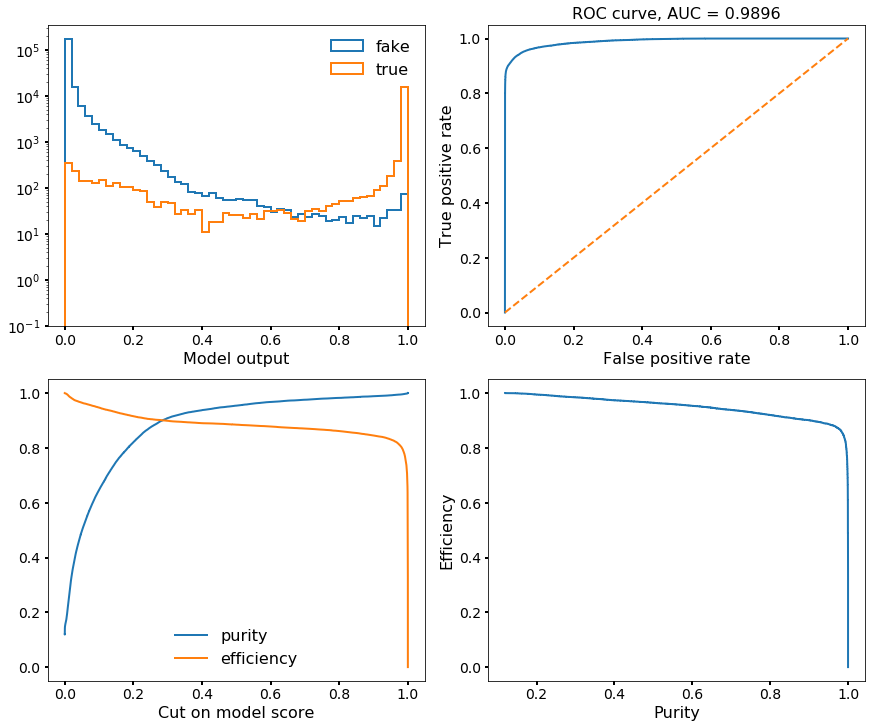

In [31]:
weights = []
truths = []
for G in all_graphs:
    weight = [G.edges[edge]['predict'][0] for edge in G.edges()]
    truth_  = [G.edges[edge]['solution'][0] for edge in G.edges()]
    weights += weight
    truths += truth_

    
weights = np.array(weights)
truths = np.array(truths)
utils_plot.plot_metrics(weights, truths, odd_th=0.5)

In [32]:
from heptrkx.postprocess import wrangler, analysis

In [33]:
all_true_tracks = wrangler.get_tracks(G, feature_name='solution')
all_predict_tracks = wrangler.get_tracks(G, feature_name='predict')
true_df = analysis.graphs_to_df(all_true_tracks)
pred_df = analysis.graphs_to_df(all_predict_tracks)

/global/project/projectdirs/atlas/xju/heptrack/gnn/code/heptrkx/heptrkx/postprocess/wrangler.py:84: RankWarning: Polyfit may be poorly conditioned
  _, _, diff = utils_fit.poly_fit_phi(z, phi)
/global/project/projectdirs/atlas/xju/heptrack/gnn/code/heptrkx/heptrkx/postprocess/wrangler.py:84: RankWarning: Polyfit may be poorly conditioned
  _, _, diff = utils_fit.poly_fit_phi(z, phi)


In [34]:
total_particles = np.unique(true_df.merge(truth, on='hit_id', how='left')['particle_id'])
print(len(total_particles))

640


In [35]:
th = 0.

In [36]:
good_pids, bad_pids = analysis.label_particles(pred_df, truth, th, ignore_noise=True)
good_trks = hits[hits['particle_id'].isin(good_pids)]

In [37]:
def print_info(res_pred):
    print(res_pred['n_correct'], res_pred['n_wrong'])

In [38]:
res_pred = analysis.summary_on_prediction(G, good_trks, pred_df)
print("Prediction Info")
print_info(res_pred)
print("True Info")
res_truth = analysis.summary_on_prediction(G, good_trks, true_df)
print_info(res_truth)

Track ML score:  0.5211204217701377
Prediction Info
454 -190
True Info
Track ML score:  0.609543175551819
491 -227


In [39]:
analysis.score_nxgraphs(all_true_tracks, truth)

[0.008247567976491364, 0.029359376, 0.016454647591672256, 0.028397913707522093]

In [40]:
analysis.score_nxgraphs(all_predict_tracks, truth)

[0.00771219990461165, 0.029359376, 0.016454647591672256, 0.028397913707522093]

In [41]:
%%time
eff, purity, true_ones, fake_ones = analysis.trk_eff_purity(all_true_tracks, all_predict_tracks)

CPU times: user 1min 37s, sys: 83 ms, total: 1min 37s
Wall time: 1min 37s


In [42]:
print("Tracking efficiency: {:.3f}".format(eff))
print("Tracking purity: {:.3f}".format(purity))

Tracking efficiency: 0.785
Tracking purity: 0.881
